In [1]:
# --- 1. Core Data Handling and Visualization ---
import pandas as pd # Data manipulation and analysis
import numpy as np # Numerical operations, especially for arrays
import matplotlib.pyplot as plt # Standard plotting library
import seaborn as sns # Enhanced statistical data visualization

# --- 2. Google Colab / Kaggle Tools ---
import kagglehub # Tool for easily downloading Kaggle datasets
from kagglehub import KaggleDatasetAdapter # Specific adapter for dataset access

# --- 3. Scikit-learn: Model Selection, Pipelines, and Basic Classifiers ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV # Splitting data, cross-validation
from sklearn.pipeline import Pipeline # Sequential application of transforms and estimators
from sklearn.neighbors import KNeighborsClassifier # Our first classification algorithm (K-NN)
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.base import clone # Utility for cloning estimators
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier


# --- 4. Scikit-learn: Preprocessing and Feature Engineering ---
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler # Standard scaling techniques
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # Encoding for categorical features
from sklearn.compose import ColumnTransformer # Applying different transformers to different columns
from sklearn.preprocessing import FunctionTransformer # Wrapping custom functions into scikit-learn transformers
from sklearn.decomposition import PCA # Principal Component Analysis (dimensionality reduction)
from pandas.plotting import scatter_matrix # Utility for pairwise scatter plots

import xgboost as xgb

# --- 5. Model Evaluation Metrics ---
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, # Basic classification metrics
    precision_score, recall_score, f1_score, # Metrics critical for imbalanced data
    roc_curve, auc, precision_recall_curve, classification_report # Curve metrics and comprehensive report
)

# --- 6. Imbalance Handling (via imblearn - needed for Phase 3 but imported now) ---
# Note: These are for advanced handling of the class imbalance problem
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE # Oversampling techniques
from imblearn.under_sampling import RandomUnderSampler # Undersampling technique
# from imblearn.pipeline import make_pipeline # Special pipeline for integrating sampling steps

# --- 7. Domain-Specific (Geocoding library, currently disabled but noted) ---
# from geopy.geocoders import Nominatim # Library for converting addresses/coords (removed from analysis but kept for reference)


try:
    import google.colab
    from google.colab.data_table import DataTable # Improves display of large DataFrames in Colab
    DataTable.max_columns = 30 # Set max columns for display
    IN_COLAB = True
except:
    IN_COLAB = False

import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load the latest version
if IN_COLAB == True:
  data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "priyamchoksi/credit-card-transactions-dataset",
    "credit_card_transactions.csv",
    # Provide any additional arguments like
    # sql_query or pandas_kwargs. See the
    # documenation for more information:
    # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
  )
else:
  data = pd.read_csv('./dataset/credit_card_transactions.csv')
num_records = len(data)
features = data.keys()
num_features = len(features)
target = data['is_fraud']

print(num_records)
print(num_features)

1296675
24


In [3]:
def coord_dist(row):
    p1 = np.array([row['lat'],row['long']])
    p2 = np.array([row['merch_lat'],row['merch_long']])
    dist_deg = np.linalg.norm(p2 - p1)
    dist_km = dist_deg * 111
    return dist_km

processed_data = data.copy()
processed_data.drop(axis=1, columns='is_fraud', inplace=True)
processed_data['trans_date_trans_time'] = pd.to_datetime(processed_data['trans_date_trans_time'])
processed_data['day_of_week'] = processed_data['trans_date_trans_time'].dt.dayofweek + 1
processed_data['month'] = processed_data['trans_date_trans_time'].dt.month
processed_data['hour_of_day'] = processed_data['trans_date_trans_time'].dt.hour + 1
processed_data['dob'] = pd.to_datetime(processed_data['dob'])
processed_data['age'] = processed_data['trans_date_trans_time'] - processed_data['dob']
processed_data['age'] = processed_data['age'].apply(lambda x: (x.days/365)).astype(int)
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].fillna(0)
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].astype(int)
processed_data['gender'] = processed_data['gender'].map({'M':1, 'F':0})
processed_data['date'] = processed_data['trans_date_trans_time'].dt.date
processed_data['num_of_tx_day'] = (processed_data.groupby(['cc_num','date'])['cc_num'].transform('count'))
processed_data.drop(['date'],axis=1,inplace=True)
processed_data['cust_merch_dist'] = processed_data.apply(coord_dist,axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target)
print(f'X train shape {X_train.shape}')
print(f'X test shape {X_test.shape}')
print(f'y train shape {y_train.shape}')
print(f'y test shape {y_test.shape}')

X train shape (1037340, 29)
X test shape (259335, 29)
y train shape (1037340,)
y test shape (259335,)


In [ ]:


cat_col = ['cc_num','category','job', 'merchant','state','street','city']
# cat2_col = ['']
drop_col = ['Unnamed: 0','trans_num','first','last','dob'
            ,'lat','long','unix_time','merch_lat','merch_long'
            , 'zip','merch_zipcode',
            'trans_date_trans_time']
scale_col = ['amt', 'city_pop','cust_merch_dist']
ct = ColumnTransformer([
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_col),
        # ('cat', OneHotEncoder(sparse_output=False),cat_col),
        ('scale', StandardScaler(), scale_col),
        ('drop','drop',drop_col),
        ], remainder='passthrough')

In [48]:
from sklearn.decomposition import PCA

X_train_ct = ct.fit_transform(X_train,y_train)
X_test_ct = ct.fit_transform(X_test,y_test)
sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy='minority')
X_train_res, y_train_res = sm.fit_resample(X_train_ct, y_train)

pca = PCA(n_components=7, random_state = RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.fit_transform(X_test_ct)


In [49]:
# X_train_pca = pd.DataFrame(X_train_pca)
# X_train_pca.head()

In [50]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=RANDOM_STATE)
logreg = LogisticRegressionCV(cv=skf)
y_pred = logreg.fit(X_train_pca,y_train_res).predict(X_test_pca)

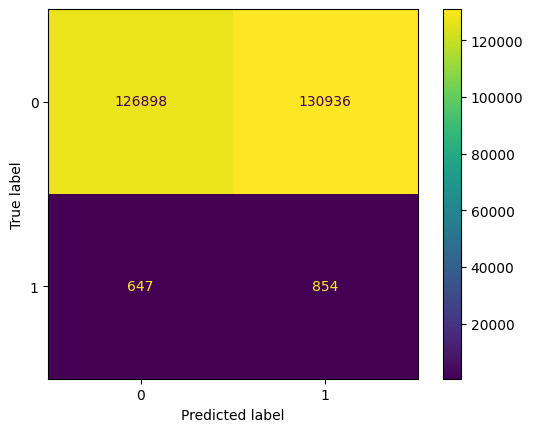

              precision    recall  f1-score   support

           0       0.99      0.49      0.66    257834
           1       0.01      0.57      0.01      1501

    accuracy                           0.49    259335
   macro avg       0.50      0.53      0.34    259335
weighted avg       0.99      0.49      0.65    259335



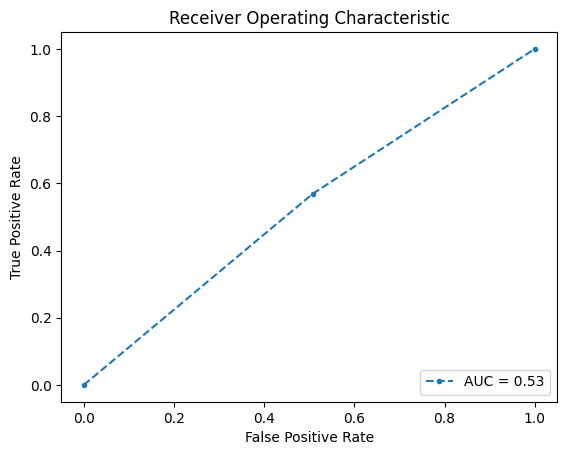

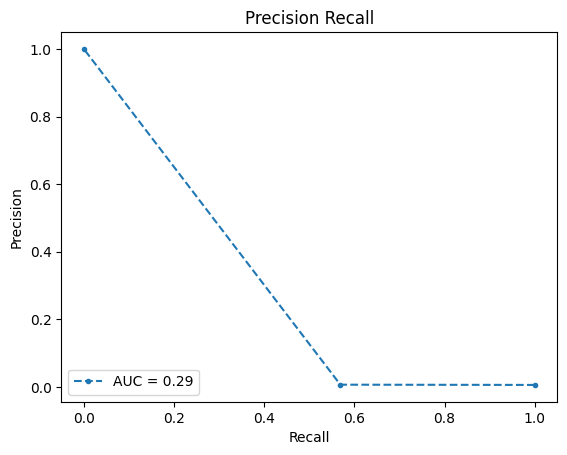

In [51]:
conf_matrix = confusion_matrix(y_true=y_test,y_pred = y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

class_report = classification_report(y_test,y_pred)
print(class_report)

fpr, tpr, ftthresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '.--', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prec, recall, prthresholds = precision_recall_curve(y_test,y_pred)
pr_auc = auc(recall,prec)
plt.title('Precision Recall')
plt.plot(recall, prec, '.--',label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()